# 02.1a: Orthographic Projections of Token Cloud

**Goal:** Visualize the 2,560-dimensional token cloud using three 2D orthographic projections.

We'll use PCA to find the top 4 principal components (directions of maximum variance) and create:
- **XY plane (top view):** Project onto PC1 and PC2, color by PC3
- **XZ plane (front view):** Project onto PC1 and PC3, color by PC2
- **YZ plane (side view):** Project onto PC2 and PC3, color by PC1

This gives us a 3D-like view of the token galaxy using only 2D projections that our brains can actually parse.

## Why PCA?

Principal Component Analysis finds the directions of **maximum variance** in the token cloud. The first few components capture the most important structure, making them ideal for visualization.

The eigenvectors of Cov(γ′) give us mutually orthogonal axes, ranked by how much the cloud spreads along them.

## Parameters

In [233]:
TENSOR_DIR = "../data/tensors"
COLORMAP = 'bwr'
POINT_SIZE = 0.1
POINT_ALPHA = 1.0
DPI = 100

# Which PCs to visualize (1-indexed, like PC1, PC2, PC3, ...)
# Try different combinations to explore the cloud:
#   1, 2, 3     - Default (highest variance directions)
#   4, 5, 6     - Next tier of variance
#   1279, 1280, 1281  - Middle of spectrum
#   2558, 2559, 2560  - Lowest variance directions
INDEX_X = 1
INDEX_Y = 2
INDEX_Z = 3

## Imports

In [234]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Centered Gamma

In [235]:
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

N, d = gamma_centered.shape

print(f"Loaded γ' (gamma_centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")

Loaded γ' (gamma_centered):
  Tokens: 151,936
  Dimensions: 2,560


## Step 2: Compute PCA (Top 4 Principal Components)

Find the eigenvectors of Cov(γ′), sorted by eigenvalue (variance explained).

In [236]:
print("Computing covariance matrix...")
# Cov(γ′) = (γ′)ᵀ γ′ / (N-1)
Cov = (gamma_centered.T @ gamma_centered) / (N - 1)

print(f"Covariance matrix shape: {Cov.shape}")
print(f"Computing eigendecomposition (this may take a moment)...\n")

# Eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending (highest variance first)
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"Top 10 eigenvalues (variance along each PC):")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}% of variance)")

print(f"\nTop 4 PCs explain: {(eigenvalues[:4].sum() / eigenvalues.sum()).item()*100:.2f}% of variance")

Computing covariance matrix...
Covariance matrix shape: torch.Size([2560, 2560])
Computing eigendecomposition (this may take a moment)...

Top 10 eigenvalues (variance along each PC):
  PC1: λ = 1.048719e-02 (0.94% of variance)
  PC2: λ = 3.177739e-03 (0.28% of variance)
  PC3: λ = 2.791374e-03 (0.25% of variance)
  PC4: λ = 2.616169e-03 (0.23% of variance)
  PC5: λ = 1.973001e-03 (0.18% of variance)
  PC6: λ = 1.805293e-03 (0.16% of variance)
  PC7: λ = 1.609086e-03 (0.14% of variance)
  PC8: λ = 1.549411e-03 (0.14% of variance)
  PC9: λ = 1.468294e-03 (0.13% of variance)
  PC10: λ = 1.389096e-03 (0.12% of variance)

Top 4 PCs explain: 1.71% of variance


## Step 3: Extract Top 4 Principal Components

In [237]:
# Extract principal components based on user-specified indices (convert to 0-indexed)
idx_x = INDEX_X - 1
idx_y = INDEX_Y - 1
idx_z = INDEX_Z - 1

X_axis = eigenvectors[:, idx_x]
Y_axis = eigenvectors[:, idx_y]
Z_axis = eigenvectors[:, idx_z]

print(f"Selected principal components:")
print(f"  X-axis: PC{INDEX_X} (variance explained: {eigenvalues[idx_x]/eigenvalues.sum()*100:.3f}%)")
print(f"  Y-axis: PC{INDEX_Y} (variance explained: {eigenvalues[idx_y]/eigenvalues.sum()*100:.3f}%)")
print(f"  Z-axis: PC{INDEX_Z} (variance explained: {eigenvalues[idx_z]/eigenvalues.sum()*100:.3f}%)")
print()

# Verify orthogonality
print("Verifying orthogonality (should all be ~0):")
print(f"  X·Y = {(X_axis @ Y_axis).item():.6e}")
print(f"  X·Z = {(X_axis @ Z_axis).item():.6e}")
print(f"  Y·Z = {(Y_axis @ Z_axis).item():.6e}")

# Verify unit length
print(f"\nVerifying unit length (should all be ~1):")
print(f"  |X| = {X_axis.norm().item():.6f}")
print(f"  |Y| = {Y_axis.norm().item():.6f}")
print(f"  |Z| = {Z_axis.norm().item():.6f}")

Selected principal components:
  X-axis: PC1 (variance explained: 0.938%)
  Y-axis: PC2 (variance explained: 0.284%)
  Z-axis: PC3 (variance explained: 0.250%)

Verifying orthogonality (should all be ~0):
  X·Y = 1.618173e-07
  X·Z = 3.725290e-09
  Y·Z = 1.713634e-07

Verifying unit length (should all be ~1):
  |X| = 1.000000
  |Y| = 0.999999
  |Z| = 1.000000


## Step 4: Project Token Cloud onto Principal Components

In [238]:
print(f"Projecting all tokens onto PC{INDEX_X}, PC{INDEX_Y}, PC{INDEX_Z}...")

# Project: multiply gamma_centered by each axis vector
# Shape: (N,) for each projection
proj_X = gamma_centered @ X_axis
proj_Y = gamma_centered @ Y_axis
proj_Z = gamma_centered @ Z_axis

print(f"Projection statistics:\n")
print(f"PC{INDEX_X} (X): range [{proj_X.min().item():.2f}, {proj_X.max().item():.2f}], std = {proj_X.std().item():.4f}")
print(f"PC{INDEX_Y} (Y): range [{proj_Y.min().item():.2f}, {proj_Y.max().item():.2f}], std = {proj_Y.std().item():.4f}")
print(f"PC{INDEX_Z} (Z): range [{proj_Z.min().item():.2f}, {proj_Z.max().item():.2f}], std = {proj_Z.std().item():.4f}")

# Convert to numpy for plotting
proj_X_np = proj_X.cpu().numpy()
proj_Y_np = proj_Y.cpu().numpy()
proj_Z_np = proj_Z.cpu().numpy()

Projecting all tokens onto PC1, PC2, PC3...
Projection statistics:

PC1 (X): range [-1.06, 0.47], std = 0.1024
PC2 (Y): range [-0.29, 0.21], std = 0.0564
PC3 (Z): range [-0.22, 0.17], std = 0.0528


## Step 5: Orthographic Projections

Create three 2D views (like architectural drawings):
- **XY plane (top view):** Looking down Z-axis, color by Z component
- **XZ plane (front view):** Looking down Y-axis, color by Y component
- **YZ plane (side view):** Looking down X-axis, color by X component

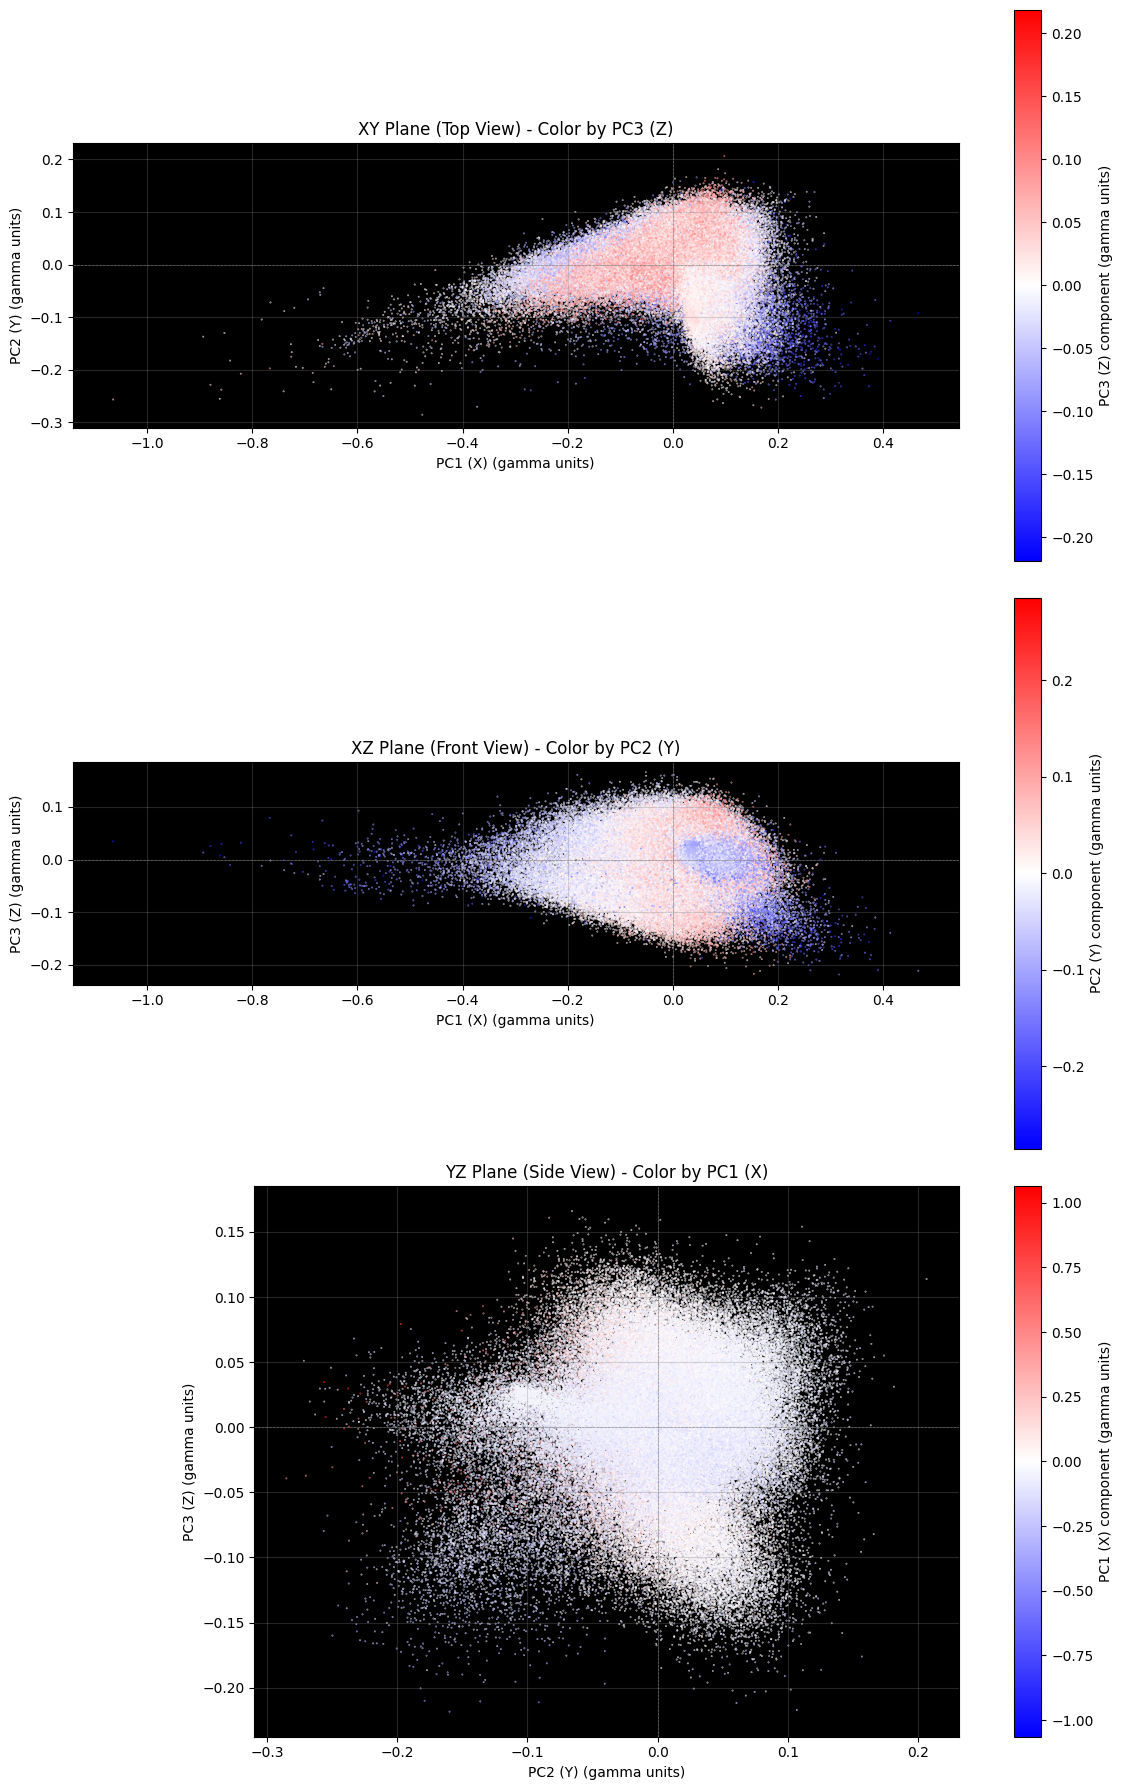


Three orthographic views of PC1 × PC2 × PC3.
Color indicates depth along the perpendicular axis.
Color limits (symmetric around zero):
  PC1: [-1.064, 1.064]
  PC2: [-0.285, 0.285]
  PC3: [-0.218, 0.218]

Camera orientation (blue = closer, red = farther):
  XY: Camera at +Z infinity looking toward screen
  XZ: Camera at +Y infinity looking toward screen
  YZ: Camera at -X infinity looking toward screen


In [239]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18), dpi=DPI, facecolor='white')

# Compute symmetric color limits for each projection
vmax_Z = np.abs(proj_Z_np).max()
vmax_Y = np.abs(proj_Y_np).max()
vmax_X = np.abs(proj_X_np).max()

# XY Plane (Top View) - color by Z
# Camera at +Z looking toward -Z: negative Z (blue) = closer
ax = axes[0]
ax.set_facecolor('black')  # Black plot background
scatter = ax.scatter(proj_X_np, proj_Y_np, c=proj_Z_np, 
                     s=POINT_SIZE, alpha=POINT_ALPHA, cmap=COLORMAP, 
                     vmin=-vmax_Z, vmax=vmax_Z, rasterized=True)
ax.set_xlabel(f'PC{INDEX_X} (X) (gamma units)', color='black')
ax.set_ylabel(f'PC{INDEX_Y} (Y) (gamma units)', color='black')
ax.set_title(f'XY Plane (Top View) - Color by PC{INDEX_Z} (Z)', color='black')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(True, alpha=0.3, color='gray')
ax.tick_params(colors='black', which='both')
ax.set_aspect('equal')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(f'PC{INDEX_Z} (Z) component (gamma units)')
cbar.set_alpha(1.0)

# XZ Plane (Front View) - color by Y
# Camera at +Y looking toward -Y: negative Y (blue) = closer
ax = axes[1]
ax.set_facecolor('black')  # Black plot background
scatter = ax.scatter(proj_X_np, proj_Z_np, c=proj_Y_np, 
                     s=POINT_SIZE, alpha=POINT_ALPHA, cmap=COLORMAP,
                     vmin=-vmax_Y, vmax=vmax_Y, rasterized=True)
ax.set_xlabel(f'PC{INDEX_X} (X) (gamma units)', color='black')
ax.set_ylabel(f'PC{INDEX_Z} (Z) (gamma units)', color='black')
ax.set_title(f'XZ Plane (Front View) - Color by PC{INDEX_Y} (Y)', color='black')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(True, alpha=0.3, color='gray')
ax.tick_params(colors='black', which='both')
ax.set_aspect('equal')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(f'PC{INDEX_Y} (Y) component (gamma units)')
cbar.set_alpha(1.0)

# YZ Plane (Side View) - color by X
# Camera at -X looking toward +X: positive X (red) = closer
# FLIP THE SIGN so red = closer (matching the other two views)
ax = axes[2]
ax.set_facecolor('black')  # Black plot background
scatter = ax.scatter(proj_Y_np, proj_Z_np, c=-proj_X_np,  # NEGATIVE X for consistent depth
                     s=POINT_SIZE, alpha=POINT_ALPHA, cmap=COLORMAP,
                     vmin=-vmax_X, vmax=vmax_X, rasterized=True)
ax.set_xlabel(f'PC{INDEX_Y} (Y) (gamma units)', color='black')
ax.set_ylabel(f'PC{INDEX_Z} (Z) (gamma units)', color='black')
ax.set_title(f'YZ Plane (Side View) - Color by PC{INDEX_X} (X)', color='black')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
ax.grid(True, alpha=0.3, color='gray')
ax.tick_params(colors='black', which='both')
ax.set_aspect('equal')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(f'PC{INDEX_X} (X) component (gamma units)')
cbar.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nThree orthographic views of PC{INDEX_X} × PC{INDEX_Y} × PC{INDEX_Z}.")
print("Color indicates depth along the perpendicular axis.")
print(f"Color limits (symmetric around zero):")
print(f"  PC{INDEX_X}: [{-vmax_X:.3f}, {vmax_X:.3f}]")
print(f"  PC{INDEX_Y}: [{-vmax_Y:.3f}, {vmax_Y:.3f}]")
print(f"  PC{INDEX_Z}: [{-vmax_Z:.3f}, {vmax_Z:.3f}]")
print()
print("Camera orientation (blue = closer, red = farther):")
print("  XY: Camera at +Z infinity looking toward screen")
print("  XZ: Camera at +Y infinity looking toward screen")  
print("  YZ: Camera at -X infinity looking toward screen")

## Summary

We've visualized the 2,560-dimensional token cloud using PCA and orthographic projections.

**Key insights:**
- The top 4 principal components capture most variance in the token cloud
- Three 2D projections give us a 3D-like understanding
- Color encodes depth along the perpendicular axis

**What to look for:**
- Is the cloud spherical or elongated?
- Are there visible clusters or structure?
- Do different views reveal different patterns?
- Where do spike tokens appear (if we color them differently)?

This is our first true **visual** look at the token galaxy in a way our 3D brains can parse!